## Assignment 3.1. Sequence Classification

## Task 1.1: Document-level Sentiment Classification

Build a Bidirectional Recurrent Neural Network (RNN) model for multi-class sentiment classification. Compare the performance with a Unidirectional RNN model. Your model (each) shall
include:

- RNN network that learns sentence representation from input sequences.
- Fully connected network that predicts sentiment label, given the learnt state representation.


Train the model by using data iterator and batch generator. Evaluate the trained model on
the provided test set.

### ==> Domain name used: yelp14

Instead of lt14, we have used yelp14 for both document and aspect classification.

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Path
absolute_path = '/content/drive/My Drive/TUE -EIT (me)/Recommender Systems/Assignment 3 - Sequential networks/Document Level/'
data_path = absolute_path + 'doc_level/'

In [0]:
import os
import sys
import codecs
import operator
import numpy as np
import re
from time import time
import matplotlib.pyplot as plt
import _pickle as cPickle
import operator
%matplotlib notebook
plt.style.use('ggplot')

from keras.preprocessing import sequence
from keras.utils.np_utils import to_categorical
import keras.backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint


In [0]:
# parameters
maxlen = 300
batch_size = 32

### Reading preprocess data

In [0]:
def read_pickle(data_path, file_name):

    f = open(os.path.join(data_path, file_name), 'rb')
    read_file = cPickle.load(f)
    f.close()

    return read_file

def save_pickle(data_path, file_name, data):

    f = open(os.path.join(data_path, file_name), 'wb')
    cPickle.dump(data, f)
    print(" file saved to: %s"%(os.path.join(data_path, file_name)))
    f.close()

In [0]:
words_idx = read_pickle(data_path, 'words_idx.pkl')
idx_words = read_pickle(data_path, 'idx_words.pkl')
data = read_pickle(data_path, 'data.pkl')
label = read_pickle(data_path, 'label.pkl')

In [0]:
# Creating train and test sets

rand_idx = np.arange(len(data))
np.random.shuffle(rand_idx)

data = data[rand_idx]
label = to_categorical(label)[rand_idx]

data_size = len(data)

test_x = data[0:1000]
test_y = label[0:1000]

dev_x = data[1000:5000]
dev_y = label[1000:5000]

train_x = data[5000:int(data_size)]
train_y = label[5000:int(data_size)]

words_idx = [x for (x, _) in sorted(words_idx.items(), key=operator.itemgetter(1))]

train_x_ = sequence.pad_sequences(train_x, maxlen)
dev_x_ = sequence.pad_sequences(dev_x, maxlen)
test_x_ = sequence.pad_sequences(test_x, maxlen)

train_x_ = np.array(train_x_)
train_y = np.array(train_y)
dev_x_ = np.array(dev_x_)
dev_y = np.array(dev_y)
test_x_ = np.array(test_x_)
test_y = np.array(test_y)

In [0]:
# Data iterator

class Dataiterator():
    '''
      1) Iteration over minibatches using next(); call reset() between epochs to randomly shuffle the data
      2) Access to the entire dataset using all()
    '''
    
    def __init__(self, X, y, seq_length=32, decoder_dim=300, batch_size=32):      
        self.X = X 
        self.y = y 
        self.num_data = len(X) # total number of examples
        self.batch_size = batch_size # batch size
        self.reset() # initial: shuffling examples and set index to 0
    
    def __iter__(self): # iterates data
        return self


    def reset(self): # initials
        self.idx = 0
        self.order = np.random.permutation(self.num_data) # shuffling examples by providing randomized ids 
        
    def __next__(self): # return model inputs - outputs per batch
        X_ids = [] # hold ids per batch 
        while len(X_ids) < self.batch_size:
            X_id = self.order[self.idx] # copy random id from initial shuffling
            X_ids.append(X_id)
            self.idx += 1 # 
            if self.idx >= self.num_data: # exception if all examples of data have been seen (iterated)
                self.reset()
                raise StopIteration()
        batch_X = self.X[np.array(X_ids)] # X values (encoder input) per batch
        batch_y = self.y[np.array(X_ids)] # y_in values (decoder input) per batch
        return batch_X, batch_y

          
    def all(self): # return all data examples
        return self.X, self.y

## Unidirectional RNN Model for document level sentiment classification

In [0]:
# model parameters
dropout= 0.5
recurrent_dropout = 0.3
early_stop_patience = 1

In [0]:
K.clear_session()

from keras.layers import Dense, Dropout, Activation, Embedding, LSTM, Input, Bidirectional
from keras.models import Model
import keras.optimizers as opt

# input layer
sentence_input = Input(shape=(None,), dtype='int32', name='sentence_input')

# layer to train the emedding
vocab_size = len(words_idx)
word_emb = Embedding(vocab_size, 300, mask_zero=True, name='word_emb')
emb_output = word_emb(sentence_input)

# RNN-based layer
lstm_layer = LSTM(300, return_sequences=False, dropout=dropout, \
              recurrent_dropout=recurrent_dropout, name='lstm')(emb_output)

# prediction layer
densed = Dense(3, name='dense')(lstm_layer)
probs = Activation('softmax')(densed)

# model
model = Model(inputs=[sentence_input], outputs=probs)
optimizer = opt.RMSprop(lr=0.001, rho=0.9, epsilon=1e-06, clipnorm=10, clipvalue=0)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sentence_input (InputLayer)  (None, None)              0         
_________________________________________________________________
word_emb (Embedding)         (None, None, 300)         3000900   
_________________________________________________________________
lstm (LSTM)                  (None, 300)               721200    
_________________________________________________________________
dense (Dense)                (None, 3)                 903       
_________________________________________________________________
activation_1 (Activation)    (None, 3)                 0         
Total params: 3,723,003
Trainable params: 3,723,003
Non-trainable params: 0
_________________________________________________________________


### Training

In [0]:
def train_generator(model, batch_train_iter, batch_val_iter):
    earlystop_callbacks = [EarlyStopping(monitor='val_loss', patience=early_stop_patience),
                     ModelCheckpoint(filepath=os.path.join('./','{epoch:02d}-{loss:.2f}.check'), \
                                     monitor='val_loss', save_best_only=False, \
                                     save_weights_only=True)
                     ]
    
    def train_gen():
        while True:
            train_batches = [[X, y] for X, y in batch_train_iter]
            for train_batch in train_batches:
                yield train_batch
                
    def val_gen():
        while True:
            val_batches = [[X, y] for X, y in batch_val_iter]
            for val_batch in val_batches:
                yield val_batch
                
    history = model.fit_generator(train_gen(), validation_data=val_gen(), \
                                  validation_steps=val_steps_epoch, steps_per_epoch=train_steps_epoch, \
                                  epochs = 20, callbacks = earlystop_callbacks)
      
    return history

In [0]:
# train batch
train_steps_epoch = len(train_x_)/batch_size
batch_train_iter = Dataiterator(train_x_, train_y, batch_size)

# validation batch
val_steps_epoch = len(dev_x_)/batch_size
batch_val_iter = Dataiterator(dev_x_, dev_y, batch_size)

In [0]:
history_unidirectional = train_generator(model, batch_train_iter, batch_val_iter)

Epoch 1/20
782/781 [==============================] - 468s 598ms/step - loss: 0.8209 - categorical_accuracy: 0.6297 - val_loss: 0.6757 - val_categorical_accuracy: 0.7060
Epoch 2/20
782/781 [==============================] - 466s 596ms/step - loss: 0.6513 - categorical_accuracy: 0.7278 - val_loss: 0.6045 - val_categorical_accuracy: 0.7472
Epoch 3/20
782/781 [==============================] - 466s 596ms/step - loss: 0.5721 - categorical_accuracy: 0.7631 - val_loss: 0.6245 - val_categorical_accuracy: 0.7370
Epoch 4/20
782/781 [==============================] - 556s 711ms/step - loss: 0.5101 - categorical_accuracy: 0.7907 - val_loss: 0.5466 - val_categorical_accuracy: 0.7612
Epoch 5/20
782/781 [==============================] - 611s 781ms/step - loss: 0.4572 - categorical_accuracy: 0.8154 - val_loss: 0.5245 - val_categorical_accuracy: 0.7808
Epoch 6/20
782/781 [==============================] - 461s 589ms/step - loss: 0.4137 - categorical_accuracy: 0.8362 - val_loss: 0.5466 - val_categoric

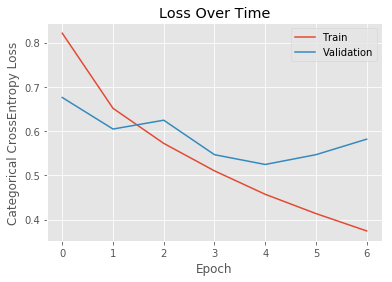

In [0]:
# Printing the Loss
plt.plot(history_unidirectional.history['loss'])
plt.plot(history_unidirectional.history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('Categorical CrossEntropy Loss')
plt.title('Loss Over Time')
plt.legend(['Train','Validation'])

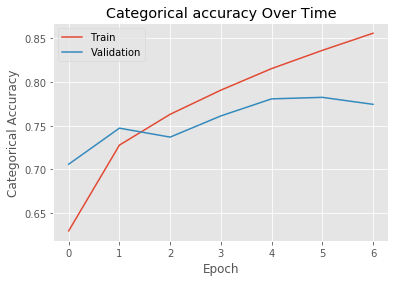

In [0]:
# Printing the Accuracy
plt.plot(history_unidirectional.history['categorical_accuracy'])
plt.plot(history_unidirectional.history['val_categorical_accuracy'])

plt.xlabel('Epoch')
plt.ylabel('Categorical Accuracy')
plt.title('Categorical accuracy Over Time')
plt.legend(['Train','Validation'])

### Evaluate

In [0]:
# Evaluate on test_set
test_loss, test_acc = model.evaluate(test_x_, test_y, verbose = 2, batch_size = 32)
print("test_loss: %.2f" % (test_loss))
print("test_acc: %.2f" % (test_acc))


test_loss: 0.61
test_acc: 0.77


## Bidirectional RNN Model for document level sentiment classification

In [0]:
bidirectional_units = 300

sentence_input = Input(shape=(None,), dtype='int32', name='sentence_input')
vocab_size = len(words_idx)
word_emb = Embedding(vocab_size, 300, mask_zero=True, name='word_emb')
emb_output = word_emb(sentence_input)

dropout= 0.5
recurrent_dropout = 0.1 
lstm_layer = Bidirectional(LSTM(bidirectional_units, return_sequences=False, dropout=dropout, recurrent_dropout=recurrent_dropout, name='bilstm'))(emb_output)
densed = Dense(3, name='dense')(lstm_layer)
probs = Activation('softmax')(densed)
biModel = Model(inputs=[sentence_input], outputs=probs)
optimizer = opt.RMSprop(lr=0.001, rho=0.9, epsilon=1e-06, clipnorm=10, clipvalue=0)
biModel.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
biModel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sentence_input (InputLayer)  (None, None)              0         
_________________________________________________________________
word_emb (Embedding)         (None, None, 300)         3000900   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 600)               1442400   
_________________________________________________________________
dense (Dense)                (None, 3)                 1803      
_________________________________________________________________
activation_2 (Activation)    (None, 3)                 0         
Total params: 4,445,103
Trainable params: 4,445,103
Non-trainable params: 0
_________________________________________________________________


### Training

In [0]:
history_bidirectional = train_generator(biModel, batch_train_iter, batch_val_iter)

Epoch 1/20
782/781 [==============================] - 925s 1s/step - loss: 0.7514 - categorical_accuracy: 0.6698 - val_loss: 0.6120 - val_categorical_accuracy: 0.7418
Epoch 2/20
782/781 [==============================] - 923s 1s/step - loss: 0.5719 - categorical_accuracy: 0.7612 - val_loss: 0.5432 - val_categorical_accuracy: 0.7700
Epoch 3/20
782/781 [==============================] - 923s 1s/step - loss: 0.4983 - categorical_accuracy: 0.7957 - val_loss: 0.5373 - val_categorical_accuracy: 0.7722
Epoch 4/20
782/781 [==============================] - 932s 1s/step - loss: 0.4400 - categorical_accuracy: 0.8240 - val_loss: 0.5666 - val_categorical_accuracy: 0.7672
Epoch 5/20
782/781 [==============================] - 924s 1s/step - loss: 0.3887 - categorical_accuracy: 0.8449 - val_loss: 0.5472 - val_categorical_accuracy: 0.7748


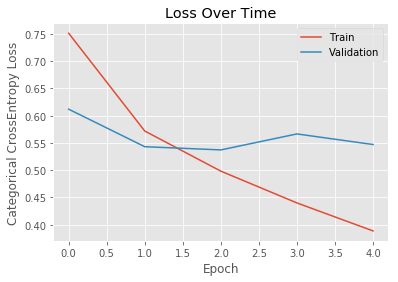

In [0]:
# Printing the Loss
plt.plot(history_bidirectional.history['loss'])
plt.plot(history_bidirectional.history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('Categorical CrossEntropy Loss')
plt.title('Loss Over Time')
plt.legend(['Train','Validation'])

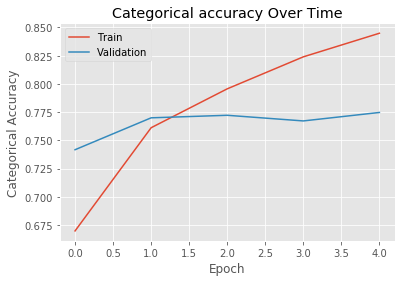

In [0]:
# Printing the Accuracy
plt.plot(history_bidirectional.history['categorical_accuracy'])
plt.plot(history_bidirectional.history['val_categorical_accuracy'])

plt.xlabel('Epoch')
plt.ylabel('Categorical Accuracy')
plt.title('Categorical accuracy Over Time')
plt.legend(['Train','Validation'])

### Evaluate

In [0]:
# Evaluation on Test set
test_loss, test_acc = biModel.evaluate(test_x_, test_y, verbose = 2, batch_size = 32)
print("test_loss: %.2f" % (test_loss))
print("test_acc: %.2f" % (test_acc))


test_loss: 0.59
test_acc: 0.76


### * Extra experiment: Bimodel with 150 hidden units instead of 300

The objective of this experiment, is to prove if the bidirectional model with 150 hidden states for looking backwards and 150 hidden states to look forward (300 in total) will achieve the same performance as the previous bidirectional model (which has 600 hidden states in total).

In [0]:
bidirectional_units = 150

sentence_input = Input(shape=(None,), dtype='int32', name='sentence_input')
vocab_size = len(words_idx)
word_emb = Embedding(vocab_size, 300, mask_zero=True, name='word_emb')
emb_output = word_emb(sentence_input)

dropout= 0.5
recurrent_dropout = 0.1 
lstm_layer = Bidirectional(LSTM(bidirectional_units, return_sequences=False, dropout=dropout, recurrent_dropout=recurrent_dropout, name='bilstm'))(emb_output)
densed = Dense(3, name='dense')(lstm_layer)
probs = Activation('softmax')(densed)
biModel_150 = Model(inputs=[sentence_input], outputs=probs)
optimizer = opt.RMSprop(lr=0.001, rho=0.9, epsilon=1e-06, clipnorm=10, clipvalue=0)
biModel_150.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
biModel_150.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sentence_input (InputLayer)  (None, None)              0         
_________________________________________________________________
word_emb (Embedding)         (None, None, 300)         3000900   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 300)               541200    
_________________________________________________________________
dense (Dense)                (None, 3)                 903       
_________________________________________________________________
activation_4 (Activation)    (None, 3)                 0         
Total params: 3,543,003
Trainable params: 3,543,003
Non-trainable params: 0
_________________________________________________________________


In [0]:
history_bidirectional_150 = train_generator(biModel, batch_train_iter, batch_val_iter)

Instructions for updating:
Use tf.cast instead.
Epoch 1/20
782/781 [==============================] - 1046s 1s/step - loss: 0.8641 - categorical_accuracy: 0.5946 - val_loss: 0.8052 - val_categorical_accuracy: 0.6435
Epoch 2/20
782/781 [==============================] - 1024s 1s/step - loss: 0.7107 - categorical_accuracy: 0.6874 - val_loss: 0.7811 - val_categorical_accuracy: 0.6442
Epoch 3/20
782/781 [==============================] - 1025s 1s/step - loss: 0.6293 - categorical_accuracy: 0.7293 - val_loss: 0.7168 - val_categorical_accuracy: 0.6760
Epoch 4/20
782/781 [==============================] - 1039s 1s/step - loss: 0.5718 - categorical_accuracy: 0.7604 - val_loss: 0.7747 - val_categorical_accuracy: 0.6795
